In [6]:
import my_functions.functions_general as fg
# import importlib
# importlib.reload(fg)
import my_functions.singularities as sing
import my_functions.beams_and_pulses as bp
import numpy as np
import scipy.io as sio
import knots_ML.center_beam_search as cbs
import matplotlib.pyplot as plt

In [7]:
# reading the field
# test_hopf_turb_path = ('C:\\WORK\\CODES\\OAM_research\\knots_ML\\'
#                          'data\\Efield_SR_9.000000e-01.mat')
# test_hopf_turb = np.array(sio.loadmat(test_hopf_turb_path, appendmat=False)['Efield'])[:, :, 0]
#
test_hopf_turb_path = ('C:\\Users\\Cmex-\\Box\\Knots Exp\\'
                       'Experimental Data\\7-13-2022\\Field SR = 0.85\\3foil_turb_1.mat')
test_hopf_turb = np.array(sio.loadmat(test_hopf_turb_path, appendmat=False)['U'])

In [8]:
# normalization
field_init = test_hopf_turb / np.sqrt(np.sum(np.abs(test_hopf_turb) ** 2))

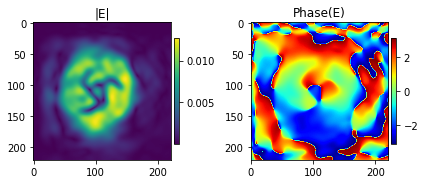

In [9]:
# plotting
def plot_field(field):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # ax1.plot([1, 2], [2, 1])
    # ax2.plot([1, 2], [1, 2])
    image1 = ax1.imshow(np.abs(field))
    ax1.set_title('|E|')
    plt.colorbar(image1, ax=ax1, shrink=0.4, pad=0.02, fraction=0.1)
    image2 = ax2.imshow(np.angle(field), cmap='jet')
    ax2.set_title('Phase(E)')
    plt.colorbar(image2, ax=ax2, shrink=0.4, pad=0.02, fraction=0.1)
    plt.tight_layout()
    plt.show()
plot_field(field_init)

In [10]:
# Finding the beam waist
shape = np.shape(field_init)
xyMesh_init = fg.create_mesh_XY(xRes=shape[0], yRes=shape[1])
width = cbs.find_width(field_init, mesh=xyMesh_init, width=shape[1] // 8, widthStep=1)
print(f'Approximate beam waist: {width}')

28 17.20294824004555
26 17.130487400285915
25 17.03860248432445
24 16.87898192860519
23 16.568040460061695
22 16.405061566895007
21 16.440430286708136
Approximate beam waist: 22


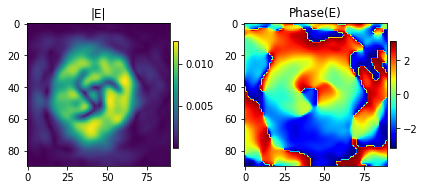

In [11]:
# 2D Interpolation
interpol_field = fg.interpolation_complex(field_init, mesh=xyMesh_init, fill_value=False)
xyMesh_interpol = fg.create_mesh_XY(xRes=90, yRes=90, xMinMax=[-100, 100], yMinMax=[-100, 100])
field_interpol = interpol_field(*xyMesh_interpol)
plot_field(field_interpol)

In [12]:
# field to work with

# field = field_init
# xyMesh = xyMesh_init
field = field_interpol
xyMesh = xyMesh_interpol

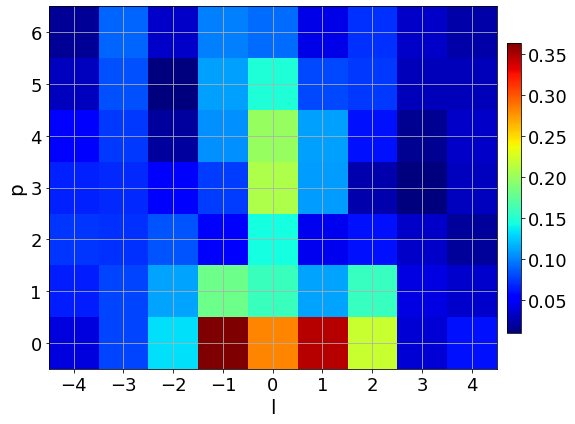

In [17]:
# plotting the LG spectrum
moments = {'p':(0, 6), 'l':(-4, 4)}
spec = cbs.LG_spectrum(field.T, **moments, mesh=xyMesh, plot=True, width=width * 2, k0=1)

In [ ]:
# finding the beam center and tilt
moments.update({'p0':(0, 4), 'l0':(-4, 2)})
x, y, eta, gamma = cbs.beamFullCenter(field, xyMesh,
                                      stepXY=(1, 1), stepEG=(3/180*np.pi, 1/180*np.pi),
                                      **moments, threshold=1,
                                    width=width, k0=1, x=0, y=0, eta2=0., gamma=0.)

In [ ]:
# "untilting" and "unshifting" the beam
# x=-3, y=-2, eta=30.0*, gamma=2.0*, var=0.8615898043663675
crop_size = (10, 10)
shape = np.shape(field)
field_untilted = cbs.removeTilt(field, xyMesh, eta=-eta, gamma=gamma, k=1)
field_cropped = field_untilted[shape[0]//2 - x - crop_size[0]:shape[0]//2 - x + crop_size[0],
                               shape[1]//2 - y - crop_size[1]:shape[1]//2 - y + crop_size[1]]
plot_field(field[:80, :75])
plot_field(field_untilted[:80, :75])
plot_field(field_cropped)

In [ ]:
# propagation
field_z = fg.propagator_split_step_3D_linear(field, dz=0.8, zSteps=30)
plot_field(field_z[:, :, -1])
field_untilted_z = fg.propagator_split_step_3D_linear(field_untilted, dz=0.8, zSteps=20)
plot_field(field_untilted_z[:, :, -1])

In [ ]:
# Это можно будет удалить !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# propagation interpolated
def one_plane_propagator(fieldPlane, dz, stepsNumber_p, stepsNumber_m=None, n0=1, k0=1):  # , shapeWrong=False
    if stepsNumber_m is None:
        stepsNumber_m = stepsNumber_p
    fieldPropMinus = fg.propagator_split_step_3D_linear(fieldPlane, dz=-dz, zSteps=stepsNumber_p, n0=n0, k0=k0)

    fieldPropPLus = fg.propagator_split_step_3D_linear(fieldPlane, dz=dz, zSteps=stepsNumber_m, n0=n0, k0=k0)
    fieldPropTotal = np.concatenate((np.flip(fieldPropMinus, axis=2), fieldPropPLus[:, :, 1:-1]), axis=2)
    return fieldPropTotal

In [ ]:
from knots_ML.processing_dots import plotDots
field_z = one_plane_propagator(field, dz=1.8, stepsNumber_p=40, stepsNumber_m=15)
plot_field(field_z[:, :, -1])
crop_size = (20, 20)
field_z_cropped = field_z[shape[0]//2 - crop_size[0]:shape[0]//2 + crop_size[0],
                               shape[1]//2 - crop_size[1]:shape[1]//2 + crop_size[1], :]
dots = sing.get_singularities(np.angle(field_z_cropped), axesAll=True)
plotDots(dots, dots, color='black', show=False, size=10)
# field_untilted_z = fg.propagator_split_step_3D_linear(field_untilted, dz=0.8, zSteps=20)
# plot_field(field_untilted_z[:, :, -1])

In [ ]:
field_z = one_plane_propagator(field, dz=1.8, stepsNumber_p=40, stepsNumber_m=15)
plot_field(field_z[:, :, -1])
crop_size = (15, 20)
field_z_cropped = field_z[shape[0]//2 - x - crop_size[0]:shape[0]//2 - x + crop_size[0],
                               shape[1]//2 - y - crop_size[1]:shape[1]//2 - y + crop_size[1], :]
dots = sing.get_singularities(np.angle(field_z_cropped), axesAll=True)
plotDots(dots, dots, color='black', show=False, size=10)